In [13]:
import os
import numpy as np
from tqdm import tqdm
from pymatgen.core import Structure
from pymatgen.io.vasp.outputs import Vasprun
from siman.calc_manage import smart_structure_read

from itertools import combinations
from scipy.constants import physical_constants

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


def count_nn(path_to_poscar: str, magnetic_atoms: list) -> dict:
    """
    calculated the number of nearest neighbors,
    to fit into the Heisenberg model.
    Get a path to POSCAR structure as an input,
    To avoid errors one should use prettified POSCAR,
    use poscar_prettifier() function first.

    Args:
        poscar_path     (str)  - path to the POSCAR file
        magnetic_atoms  (list) - two type of atoms to be treated as a magnetic
                            with an opposite spins (up/down).
                            your POSCAR should contain this two types of atoms.
    Returns:
        dict{distance : number_of_neibours}
    """
    if not os.path.exists(path_to_poscar):
        print(f'File {path_to_poscar} does not exist!')
        return None
    st = smart_structure_read(path_to_poscar)
    st = st.replic([6, 6, 6])
    out = st.nn(i=1, n=500, silent=1)

    a = list(zip(out['el'][1:], out['dist'][1:]))
    # collect all the unique distances
    unique_dist = set(round(i[1], 3) for i in a if i[0] in magnetic_atoms)
    magnetic_dist_lst = [(el, round(dist, 3)) for el, dist in a if el in magnetic_atoms]

    dist_neighbNum = {_: 0 for _ in unique_dist}  # key- distane, value list of
    # neighbours at 1st 2nd 3d coordination spheres

    for dist in unique_dist:
        for el, distance in magnetic_dist_lst:
            if dist == distance:
                if el == magnetic_atoms[0]:
                    dist_neighbNum[dist] += 1
                elif el == magnetic_atoms[1]:
                    dist_neighbNum[dist] -= 1
    return dist_neighbNum


def get_coefficients(poscars_to_check: list, magnetic_atoms: list, up_to=3) -> list:
    """
    As a result this function will return coefficients,
    For E0, J1 and J2 for the Hisenber model in a form of matrix.
    Combaining obtained matrix with calculated energies (E_afm) of AFM configurations,
    One can calculate E0, J1, J2, solving a system of linear equations.

    Args:
        poscars_to_check - List of paths to POCARs files that should be checked.
        up_to - how many coordinations spheres to check, default check first two.

    Example:
        poscars_to_check = ['/EuO/POSCARS2siman/POSCAR_1',
                            '/EuO/POSCARS2siman/POSCAR_2',
                            '/EuO/POSCARS2siman/POSCAR_3']
        get_coefficients(poscars_to_check)
        >>> np.array([[0,  6],
                      [4, -6],
                      [-6,  0]]
    """
    nn_matrix = []
    for path_to_poscar in tqdm(poscars_to_check):
        # get a list with number of nearest
        nn_ls = list(count_nn(path_to_poscar, magnetic_atoms=magnetic_atoms).values())
        # neighbours for the structure
        nn_matrix.append(nn_ls)  # add list to he matrix
    nn_matrix = np.array(nn_matrix)
    return nn_matrix[..., :up_to]


def get_exchange_couplings(nn_matrix: list, energies_afm: list, spin: float) -> list:
    """
    Returns three float numbers: E0, J1, J2 respectively.
        E0 - is the part of total energy independent of the spin configuration
        J1, J2 - are the first and second nearest neighbor exchange constants

    Example:
        nn_matrix = np.array([[ 0  6],
                              [ 4 -6],
                              [-6  0]])

        energies_afm = np.array([-41.614048,
                                 -41.611114,
                                 -41.59929])

        get_exchange_coeff(nn_matrix, energies_afm)
        >>>-41.609258249 0.000105484126 5.0685185185e-05
    """
    nn_matrix = nn_matrix * spin * (spin + 1)
    nn_matrix = np.append(np.ones([len(nn_matrix), 1]), nn_matrix, 1)
    E0, J1, J2, J3 = np.linalg.solve(nn_matrix, energies_afm)
    return E0, abs(J1), abs(J2), abs(J3)


def calculate_Tc(J1: float, J2: float, J3: float, z1: int, z2: int, z3: int) -> float:
    k_B = physical_constants['Boltzmann constant in eV/K'][0]
    T_c = (J1 * z1 + J2 * z2 + J3 * z3) / (3 * k_B)
    return T_c


def total_num_neighbours(path_to_poscar: str, magnetic_atoms: list) -> list:
    """
    Return total number of magnetic_atoms in first,
    second and third coordination spheres z1, z2, z3 respectively.
    Since this number is constant for particular structure and will be the
    same for all generated supercells you can use whatever POSCAR file you want.

    Args:
        path_to_poscar  (str)
        magnetic_atoms  (list)  - list of atoms which suppose to be magnetic in
        given structure.e.g [Fe, Co] or just [Fe] if there is only one type
        of magnetic atoms.

    Example:
        # BCC Iron case
        path_to_poscar = './vasp_inputs/afm1/POSCAR'
        total_num_neighbours(path_to_poscar, magnetic_atoms = ['Fe'])
        >>> [8, 6, 12, 24]

    """
    assert os.path.exists(path_to_poscar), f'File {path_to_poscar} does not exist!'
    num_neighb = [abs(i) for i in list(
        count_nn(path_to_poscar, magnetic_atoms=magnetic_atoms).values())]
    return num_neighb[:4]



def get_Tc_list(num_of_structures: int, nn_matrix, energies_afm: list, z1: int, z2: int, z3: int, spin: float):
    all_combinations = list(combinations(range(0, num_of_structures), 4))
    Tc_list = []
    Eg_list = []  # energy from the geometrly itself
    J1_list = []
    J2_list = []
    J3_list = []
    combination_list = []
    num_of_singular_matrix = 0

    for combination in all_combinations:
        matrix = nn_matrix[(combination), ...]
        energies = energies_afm[(combination), ...]
        try:
            Eg, J1, J2, J3 = get_exchange_couplings(matrix,
                                                    energies,
                                                    spin=spin)
            Tc = calculate_Tc(J1, J2, J3, z1=z1, z2=z2, z3=z3)
            Tc_list.append(Tc)
            Eg_list.append(Eg)
            J1_list.append(J1)
            J2_list.append(J2)
            J3_list.append(J3)
            combination_list.append(combination)
        except:
            num_of_singular_matrix += 1
    return Tc_list, Eg_list, J1_list, J2_list, J3_list, combination_list, num_of_singular_matrix


def get_results(input_folder: str, num_of_structures: int, magnetic_atoms: list, SPIN: float):
    En_dict = get_all_energies(input_folder, num_of_structures)

    energies_afm = np.array(list(En_dict.values()), dtype='float')

    z1, z2, z3, z4 = total_num_neighbours(path_to_poscar=os.path.join(input_folder, 'vasp_inputs/afm1/POSCAR'),
                                          magnetic_atoms=magnetic_atoms)

    siman_input_path = os.path.join(input_folder, 'siman_inputs')

    poscars_to_check = [os.path.join(
        siman_input_path, f'POSCAR_{i}') for i in range(1, num_of_structures + 1)]

    nn_matrix = get_coefficients(poscars_to_check, magnetic_atoms=magnetic_atoms)

    Tc_list, Eg_list, J1_list, J2_list, J3_list, combination_list, num_of_singular_matrix = get_Tc_list(num_of_structures=num_of_structures,
                                                                                                        nn_matrix=nn_matrix,
                                                                                                        energies_afm=energies_afm,
                                                                                                        z1=z1,
                                                                                                        z2=z2,
                                                                                                        z3=z3,
                                                                                                        spin=SPIN)
    out_dict = {'Tc_list': Tc_list,
                'num_of_singular_matrix': num_of_singular_matrix,
                'Eg_list': Eg_list,
                'J1_list': J1_list,
                'J2_list': J2_list,
                'J3_list': J3_list,
                'energies_afm': energies_afm,
                'nn_matrix': nn_matrix,
                'combination_list': combination_list,
                'z1': z1,
                'z2': z2,
                'z3': z3}

    return out_dict


def get_ratio(path_to_structure : str, initial_atoms_num : float) -> float:
    tmp_strucuture = Structure.from_file(path_to_structure)
    ratio = len(tmp_strucuture) / initial_atoms_num
    return ratio

def get_all_energies(in_path: str) -> dict:
    """
    Args:
        in_path           (str)
        num_of_structures (int)
    Return:
        E_dict (dict) {id_of_structure : E_tot}

    Function parse all the folder with VASP calculations
    for AFM structures and returns the dictionary in format
    {id_of_structure : E_tot}
    """
    initial_atoms_num = len(Structure.from_file(os.path.join(input_path, 'POSCAR')))
    vasp_inputs_path = os.path.join(input_path, 'vasp_inputs')

    E_dict = {}
    for magnetic_conf in tqdm(os.listdir(vasp_inputs_path)):
        vasprun_path = os.path.join(vasp_inputs_path, magnetic_conf, 'vasprun.xml')
        if os.path.exists(vasprun_path):
            vasprun_xml = Vasprun(vasprun_path,
                                  parse_dos=False,
                                  parse_eigen=False)

            structure_path = os.path.join(vasp_inputs_path, magnetic_conf, 'POSCAR')
            ratio = get_ratio(structure_path, initial_atoms_num)

            if vasprun_xml.converged:
                E_dict[magnetic_conf] = (vasprun_xml.final_energy / ratio)
    return E_dict

In [2]:
def total_num_neighbours(path_to_poscar: str, magnetic_atoms: list) -> list:
    """
    Return total number of magnetic_atoms in first,
    second and third coordination spheres z1, z2, z3 respectively.
    Since this number is constant for particular structure and will be the
    same for all generated supercells you can use whatever POSCAR file you want.

    Args:
        path_to_poscar  (str)
        magnetic_atoms  (list)  - list of atoms which suppose to be magnetic in
        given structure.e.g [Fe, Co] or just [Fe] if there is only one type
        of magnetic atoms.

    Example:
        # BCC Iron case
        path_to_poscar = './vasp_inputs/afm1/POSCAR'
        total_num_neighbours(path_to_poscar, magnetic_atoms = ['Fe'])
        >>> [8, 6, 12, 24]

    """
    assert os.path.exists(path_to_poscar), f'File {path_to_poscar} does not exist!'
    num_neighb = [abs(i) for i in list(
        count_nn(path_to_poscar, magnetic_atoms=magnetic_atoms).values())]
    return num_neighb

def count_nn(path_to_poscar: str, magnetic_atoms: list) -> dict:
    """
    calculated the number of nearest neighbors,
    to fit into the Heisenberg model.
    Get a path to POSCAR structure as an input,
    To avoid errors one should use prettified POSCAR,
    use poscar_prettifier() function first.

    Args:
        poscar_path     (str)  - path to the POSCAR file
        magnetic_atoms  (list) - two type of atoms to be treated as a magnetic
                            with an opposite spins (up/down).
                            your POSCAR should contain this two types of atoms.
    Returns:
        dict{distance : number_of_neibours}
    """
    if not os.path.exists(path_to_poscar):
        print(f'File {path_to_poscar} does not exist!')
        return None
    st = smart_structure_read(path_to_poscar)
    st = st.replic([6, 6, 6])
    out = st.nn(i=1, n=500, silent=1)

    a = list(zip(out['el'][1:], out['dist'][1:]))
    # collect all the unique distances
    unique_dist = set(round(i[1], 3) for i in a if i[0] in magnetic_atoms)
    magnetic_dist_lst = [(el, round(dist, 3)) for el, dist in a if el in magnetic_atoms]

    dist_neighbNum = {_: 0 for _ in unique_dist}  # key- distane, value list of
    # neighbours at 1st 2nd 3d coordination spheres

    for dist in unique_dist:
        for el, distance in magnetic_dist_lst:
            if dist == distance:
                if el == magnetic_atoms[0]:
                    dist_neighbNum[dist] += 1
                elif el == magnetic_atoms[1]:
                    dist_neighbNum[dist] -= 1
    return dist_neighbNum

def get_nn_list(path_to_poscar : str, magnetic_atom : str) -> list:
    nn_list = list(count_nn(path_to_poscar, magnetic_atoms=[magnetic_atom, 'Po']).values())
    return nn_list

def get_nn_dict(input_path : str, magnetic_atom=str, num_structures = None) -> dict:
    nn_dict = dict()
    fm_nn_list = get_nn_list(os.path.join(input_path, 'POSCAR'), magnetic_atom=magnetic_atom)
    siman_ins_path = os.path.join(input_path, 'siman_inputs')
    for poscar_name in tqdm(os.listdir(siman_ins_path)):
        struct_id = poscar_name.split('_')[-1]
        full_poscar_path = os.path.join(siman_ins_path, poscar_name)
        nn_lst = get_nn_list(path_to_poscar = full_poscar_path,
                             magnetic_atom=magnetic_atom)
        if num_structures:
            nn_dict[struct_id] = nn_lst[:num_structures - 1]
            nn_dict['fm0'] = fm_nn_list[:num_structures - 1]
        else:
            nn_dict[struct_id] = nn_lst
            nn_dict['fm0'] = fm_nn_list
    return nn_dict

def mergeDict(dict1 : dict, dict2: dict) -> dict:
    dict3 = {**dict1, **dict2}
    for key, value in dict3.items():
        if key in dict1 and key in dict2:
            dict3[key] = [value , dict1[key]]
    return dict3

def out_data_builder(E_dict : dict, nn_dict : dict) -> list:
    out_data_list = list(mergeDict(E_dict, nn_dict).items())
    out_data_list.sort(key=lambda i: i[1][1])
    return out_data_list

def ranked_list_getter(out_data_list : list) -> list:
    sotred_energy_list = np.array([i[1][1] for i in out_data_list])
    sorted_nn_matrix = np.array([i[1][0] for i in out_data_list])
    sorted_nn_matrix = np.append(np.ones([len(sorted_nn_matrix), 1]), sorted_nn_matrix, 1)
    return sorted_nn_matrix, sotred_energy_list

def equation_sys_builder(input_path : str, magnetic_atom : str):
    E_dict = get_all_energies(in_path = input_path)
    num_structures = len(E_dict)
    nn_dict = get_nn_dict(input_path,
                          magnetic_atom = magnetic_atom,
                          num_structures = num_structures)

    out_data_list = out_data_builder(E_dict, nn_dict)
    sorted_nn_matrix, sotred_energy_list = ranked_list_getter(out_data_list)
    nn_vector = sorted_nn_matrix[0][1:].copy()
    return sorted_nn_matrix, sotred_energy_list, nn_vector

def plot_j_values(j_vector_list : list):
    j_vector_list = [abs(i) * 1000 for i in j_vector_list] # j values in meV

    plt.figure(figsize=(8, 6), dpi=100)
    for i in j_vector_list:
        plt.scatter(range(1, len(i) + 1), i, label=len(i))
    plt.grid(alpha=.4)
    plt.xlabel('Coordination sphere')
    plt.ylabel('J, meV')
    plt.legend()
    plt.show()

In [5]:
input_path = '../examples/EuO_2/'
k_B = physical_constants['Boltzmann constant in eV/K'][0]
magnetic_atom = 'Eu'
spin = 2.5

sorted_nn_matrix, sotred_energy_list, nn_vector = equation_sys_builder(input_path, magnetic_atom)

matrix_size = sorted_nn_matrix.shape[0]

j_vector_list = []

for i in range(1, matrix_size - 1):
    tmp_matrix = sorted_nn_matrix[:-i,:-i]
    tmp_energies = sotred_energy_list[:-i]
    z_vector = nn_vector[:-i]

    determinant = np.linalg.det(tmp_matrix)
    
    if determinant:
        solution = np.linalg.solve(tmp_matrix, tmp_energies)
        j_vector = solution[1:]
        j_vector_list += [j_vector]
        T_c = sum(abs(j_vector) * z_vector) / (3 * k_B)
        print(f'{i} T_c: {T_c:.2f} K')
    else:
        print(f'{i} Singular matrix')

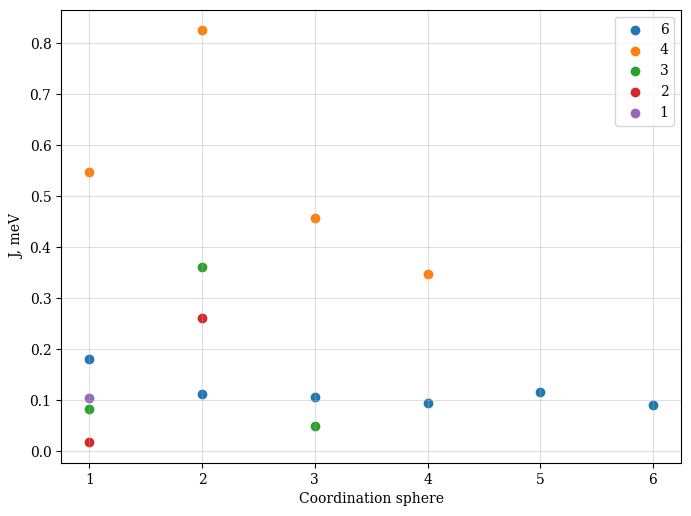

In [11]:
plot_j_values(j_vector_list)